In [65]:
import nltk
import string
import numpy as np
import pandas as pd
import pickle
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

In [3]:
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

C:\Users\zshnh\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

In [6]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook

In [7]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [8]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

# Exploratory Data Analysis
On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary.

1. __Numerical/Continuous Features__

    A. price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    B. shipping cost

2. __Categorical Features:__

   <br> A. shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer 
   <br> B. item_condition_id: The condition of the items provided by the seller 
   <br> C. name: The item's name
   <br> D. brand_name: The item's producer brand name
   <br> E. category_name: The item's single or multiple categories that are separated by "\"
   <br> F. item_description: A short description on the item that may include removed words, flagged by 'rm'

In [10]:
PATH = "D:/data_science/data/mercrari_price/"

In [11]:
train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

In [12]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [13]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [14]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [15]:
#NA Counts for train data
print(train.isnull().sum()/train.shape[0])

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004268
brand_name           0.426757
price                0.000000
shipping             0.000000
item_description     0.000003
dtype: float64


In [16]:
#NA Counts for test data
print(test.isnull().sum()/test.shape[0])

test_id              0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.004410
brand_name           0.426222
shipping             0.000000
item_description     0.000000
dtype: float64


# Target Variable: Price

The next standard check is with our response or target variables, which in this case is the price we are suggesting to the Mercari's marketplace sellers. The median price of all the items in the training is about /$267 but given the existence of some extreme values of over $100 and the maximum at $2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [17]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

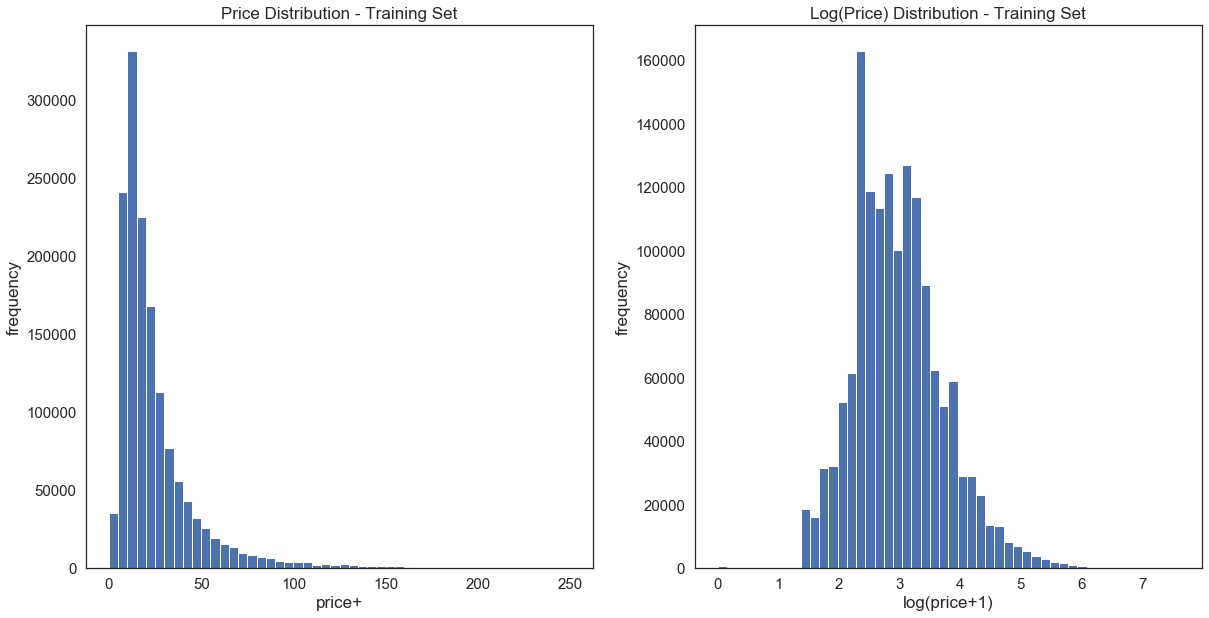

In [18]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

# Shipping

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [19]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [20]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

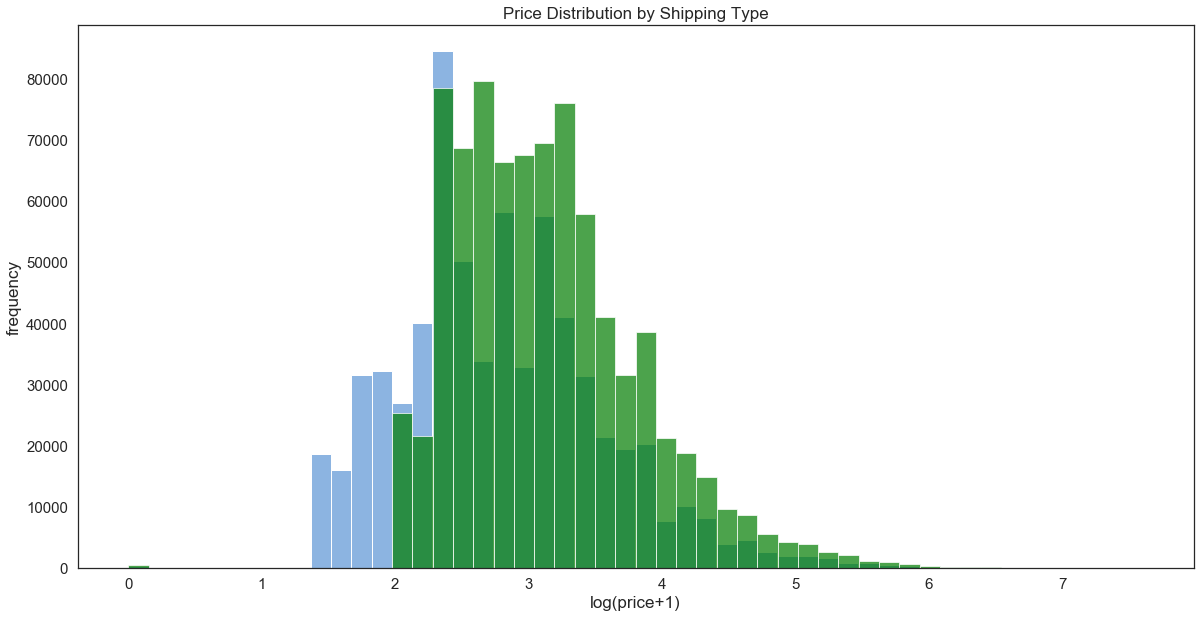

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

# Item Category
There are about __1,287__ unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the brand_name column will impact the model's prediction.

In [22]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [23]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [24]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [25]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [26]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [28]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [29]:
print("There are %d unique general category." % train['general_cat'].nunique())

There are 11 unique general category.


In [30]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [31]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


Overall, we have __11 main categories__ (114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics.

In [32]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

Handling categorical variables...


In [33]:
le.fit(np.hstack([train.general_cat, test.general_cat]))
train.general_cat = le.transform(train.general_cat)
test.general_cat = le.transform(test.general_cat)

In [34]:
le.fit(np.hstack([train.subcat_1, test.subcat_1]))
train.subcat_1 = le.transform(train.subcat_1)
test.subcat_1 = le.transform(test.subcat_1)

In [35]:
le.fit(np.hstack([train.subcat_2, test.subcat_2]))
train.subcat_2 = le.transform(train.subcat_2)
test.subcat_2 = le.transform(test.subcat_2)

In [36]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,5,103,774
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,1,30,215
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,10,58,542


In [37]:
train.brand_name.fillna('missing',inplace=True)
test.brand_name.fillna('missing',inplace=True)

In [38]:
le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)

In [39]:
stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row.split(' ')
    meaningful_words = ' '.join([w.lower() for w in my_list if not w in stops])
    return (meaningful_words)

In [40]:
train['item_description'].fillna('No item description',inplace = True)
test['item_description'].fillna('No item description',inplace = True)

In [41]:
train['item_description'] = train['item_description'].apply(lambda x: remove_stops(x))
test['item_description'] = test['item_description'].apply(lambda x: remove_stops(x))

In [42]:
#PROCESS TEXT: RAW
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

Text to seq process...


Using TensorFlow backend.


   Fitting tokenizer...
   Transforming text to seq...


In [43]:
train["seq_item_description"] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train["seq_name"] = tok_raw.texts_to_sequences(train.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())

In [44]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,5265,10.0,1,no description yet,5,103,774,"[9, 39, 49]","[3824, 8808, 6880, 193, 55, 2, 118]"
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,3889,52.0,0,this keyboard great condition works like came ...,1,30,215,"[31, 2589, 20, 6, 173, 28, 1080, 32, 42, 3148,...","[10751, 25557, 16365, 2589]"
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,4588,10.0,1,adorable top hint lace key hole back! the pale...,10,104,97,"[574, 35, 5326, 157, 854, 1257, 72, 22, 1918, ...","[7619, 10554, 635]"
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,5265,35.0,1,new tags. leather horses. retail [rm] each. st...,3,55,410,"[1, 36, 143, 6511, 194, 8, 379, 1054, 1553, 86...","[143, 2572, 14240]"
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,5265,44.0,0,complete certificate authenticity,10,58,542,"[774, 6872, 1959]","[4860, 70, 1001, 240]"


In [45]:
#SEQUENCES VARIABLES ANALYSIS
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 254


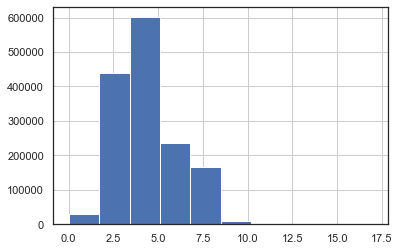

In [46]:
train.seq_name.apply(lambda x: len(x)).hist()

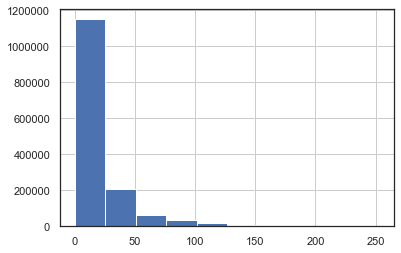

In [47]:
train.seq_item_description.apply(lambda x: len(x)).hist()

In [48]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(train.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_GEN_CATEGORY = np.max([train.general_cat.max(), test.general_cat.max()])+1
MAX_SUB_CATEGORY_1 = np.max([train.subcat_1.max(), test.subcat_1.max()])+1
MAX_SUB_CATEGORY_2 = np.max([train.subcat_2.max(), test.subcat_2.max()])+1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()])+1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F498E04E48>]],
      dtype=object)

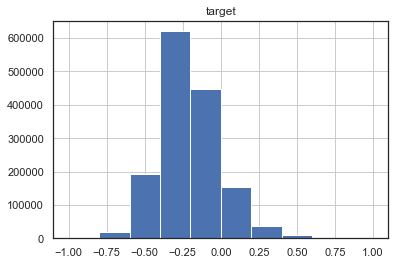

In [49]:
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [50]:
#EXTRACT DEVELOPTMENT TEST
train_dt, valid_test_dt = train_test_split(train, random_state=123, train_size=0.7)
print(train_dt.shape)
print(valid_test_dt.shape)

(1037774, 14)
(444761, 14)


In [51]:
validation_dt, test_dt = train_test_split(valid_test_dt, random_state=123, train_size=0.5)
print(validation_dt.shape)
print(test_dt.shape)

(222380, 14)
(222381, 14)


In [52]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

In [53]:
def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'general_category': np.array(dataset.general_cat)
        ,'subcategory_1': np.array(dataset.subcat_1)
        ,'subcategory_2': np.array(dataset.subcat_2)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

In [54]:
X_train = get_keras_data(train_dt)
X_valid = get_keras_data(validation_dt)
X_test = get_keras_data(test_dt)
X_unseen = get_keras_data(test)

In [ ]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

In [ ]:
from tf.keras.layers import Input

In [55]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [56]:
def const_model():
    
    #params
    
    dr_r = 0.1
    
    #input
    name = keras.Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = keras.Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = keras.Input(shape=[1], name="brand_name")
    general_category_name = keras.Input(shape=[1], name="general_category")
    subcategory_1_name = keras.Input(shape=[1], name="subcategory_1")
    subcategory_2_name = keras.Input(shape=[1], name="subcategory_2")
    item_condition = keras.Input(shape=[1], name="item_condition")
    num_vars = keras.Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")   #For Shipping
    
    #Embeddings layers
    emb_name = layers.Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = layers.Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = layers.Embedding(MAX_BRAND, 10)(brand_name)
    emb_general_cat = layers.Embedding(MAX_GEN_CATEGORY, 10)(general_category_name)
    emb_subcat_1 = layers.Embedding(MAX_SUB_CATEGORY_1, 20)(subcategory_1_name)
    emb_subcat_2 = layers.Embedding(MAX_SUB_CATEGORY_2, 20)(subcategory_2_name)
    emb_item_condition = layers.Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = layers.GRU(16) (emb_item_desc)
    rnn_layer2 = layers.GRU(8) (emb_name)
    
    main_p1 = layers.concatenate([
        layers.Flatten() (emb_brand_name)
        , layers.Flatten() (emb_general_cat)
        , layers.Flatten() (emb_subcat_1)
        , layers.Flatten() (emb_subcat_2)
        , layers.Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    
    main_p1 = layers.Dropout(dr_r) (layers.Dense(128) (main_p1))
    main_p1 = layers.Dropout(dr_r) (layers.Dense(64) (main_p1))
    
    #output
    output = layers.Dense(1, activation="linear") (main_p1)
    
    #model object
    model = keras.Model([name, item_desc, brand_name
                   , general_category_name,subcategory_1_name,subcategory_2_name, item_condition, num_vars], output)
    
    model.compile(optimizer="adam",loss="mse",metrics=['mae'])
    
    return model
    

In [69]:
def const_model2():
    
    #params
    
    dr_r = 0.1
    
    #input
    name = keras.Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = keras.Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = keras.Input(shape=[1], name="brand_name")
    general_category_name = keras.Input(shape=[1], name="general_category")
    subcategory_1_name = keras.Input(shape=[1], name="subcategory_1")
    subcategory_2_name = keras.Input(shape=[1], name="subcategory_2")
    item_condition = keras.Input(shape=[1], name="item_condition")
    num_vars = keras.Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = layers.Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = layers.Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = layers.Embedding(MAX_BRAND, 10)(brand_name)
    emb_general_cat = layers.Embedding(MAX_GEN_CATEGORY, 10)(general_category_name)
    emb_subcat_1 = layers.Embedding(MAX_SUB_CATEGORY_1, 20)(subcategory_1_name)
    emb_subcat_2 = layers.Embedding(MAX_SUB_CATEGORY_2, 20)(subcategory_2_name)
    emb_item_condition = layers.Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = layers.LSTM(16) (emb_item_desc)
    rnn_layer2 = layers.LSTM(8) (emb_name)
    
    main_p1 = layers.concatenate([
        layers.Flatten() (emb_brand_name)
        , layers.Flatten() (emb_general_cat)
        , layers.Flatten() (emb_subcat_1)
        , layers.Flatten() (emb_subcat_2)
        , layers.Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    
    main_p1 = layers.Dropout(dr_r) (layers.Dense(128) (main_p1))
    main_p1 = layers.Dropout(dr_r) (layers.Dense(64) (main_p1))
    #main_p1 = layers.BatchNormalization()
    #output
    output = layers.Dense(1, activation="linear") (main_p1)
    
    #model object
    model = keras.Model([name, item_desc, brand_name
                   , general_category_name,subcategory_1_name,subcategory_2_name, item_condition, num_vars], output)
    
    model.compile(optimizer="adam",loss="mse",metrics=['mae'])
    
    return model
    

In [57]:
model_1 = const_model()

In [58]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
general_category (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
subcategory_1 (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
subcategory_2 (InputLayer)      [(None, 1)]          0                                            
______________________________________________________________________________________________

In [70]:
model_2 = const_model2()

In [59]:
BATCH_SIZE = 20000
epochs = 6

model_1.fit(X_train, train_dt.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, validation_dt.target),verbose=1)

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52/52 [==============================] - ETA: 0s - loss: 0.0343 - mae: 0.1407WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F5130E2EA0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [71]:
BATCH_SIZE = 20000
epochs = 6

model_2.fit(X_train, train_dt.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, validation_dt.target),verbose=1)

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52/52 [==============================] - ETA: 0s - loss: 0.0337 - mae: 0.1399WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F5270C3C80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [61]:
test_preds = model_1.predict(X_test)
test_preds = target_scaler.inverse_transform(test_preds)
test_preds = np.exp(test_preds)+1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [72]:
test_preds_2 = model_2.predict(X_test)
test_preds_2 = target_scaler.inverse_transform(test_preds_2)
test_preds_2 = np.exp(test_preds_2)+1

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [62]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [66]:
#mean_absolute_error, mean_squared_log_error
y_true = np.array(test_dt.price.values)
y_pred = test_preds[:,0]
test_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on test data: "+str(test_rmsle))

 RMSLE error on test data: 0.487476858323207


In [74]:
#mean_absolute_error, mean_squared_log_error
y_true = np.array(test_dt.price.values)
y_pred_2 = test_preds_2[:,0]
test_rmsle_2 = rmsle(y_true, y_pred_2)
print(" RMSLE error on test data: "+str(test_rmsle_2))

 RMSLE error on test data: 0.4855880726696572


In [77]:
unseen_dt_pred = model_2.predict(X_unseen)
unseen_dt_pred = target_scaler.inverse_transform(unseen_dt_pred)
unseen_dt_pred = np.exp(unseen_dt_pred)+1